# Obtaining a Data Frame From Scraping All Books Available in Lectulandia

<b>Author: Christian Guerra</b>

<b>Date: January 24 2022</b>

On this Jupyter Notebook we will obtain a dataframe with all of the books available in lectulandia, this process will be explained step by step in this notebook. The database will include Author, Title, Genre, Author Country, Author Language, PDF download link, Epub download link.

You could access the Lectulandia website here: https://www.lectulandia.co

This information is useful since it is one of the largest websites to obtain books in the Spanish language, access to this information is harder to obtain than in English and creating a database could be useful for machine learning projects.

### Importing Packages:

In [1]:
from bs4 import BeautifulSoup # this module helps in web scrapping
import requests  # this module helps us obtain the web page
import pandas as pd
import numpy as np

## Part 1: Creating a database from the first page

Lectulandia has a section called 'Libros' were we could view every book that is available to download on the site. There are 24 books per page and more than 1.900 pages to scroll through.

We will use BeautifulSoup to extract data from the website. We use 'html' and 'response.content' since this obtains spanish characters like accents and ñ.

In part 1 we obtain information only from the first page of the list of books. Our columns will be: author, book, book website.

### <b>Screenshot of the 1st page:</b>

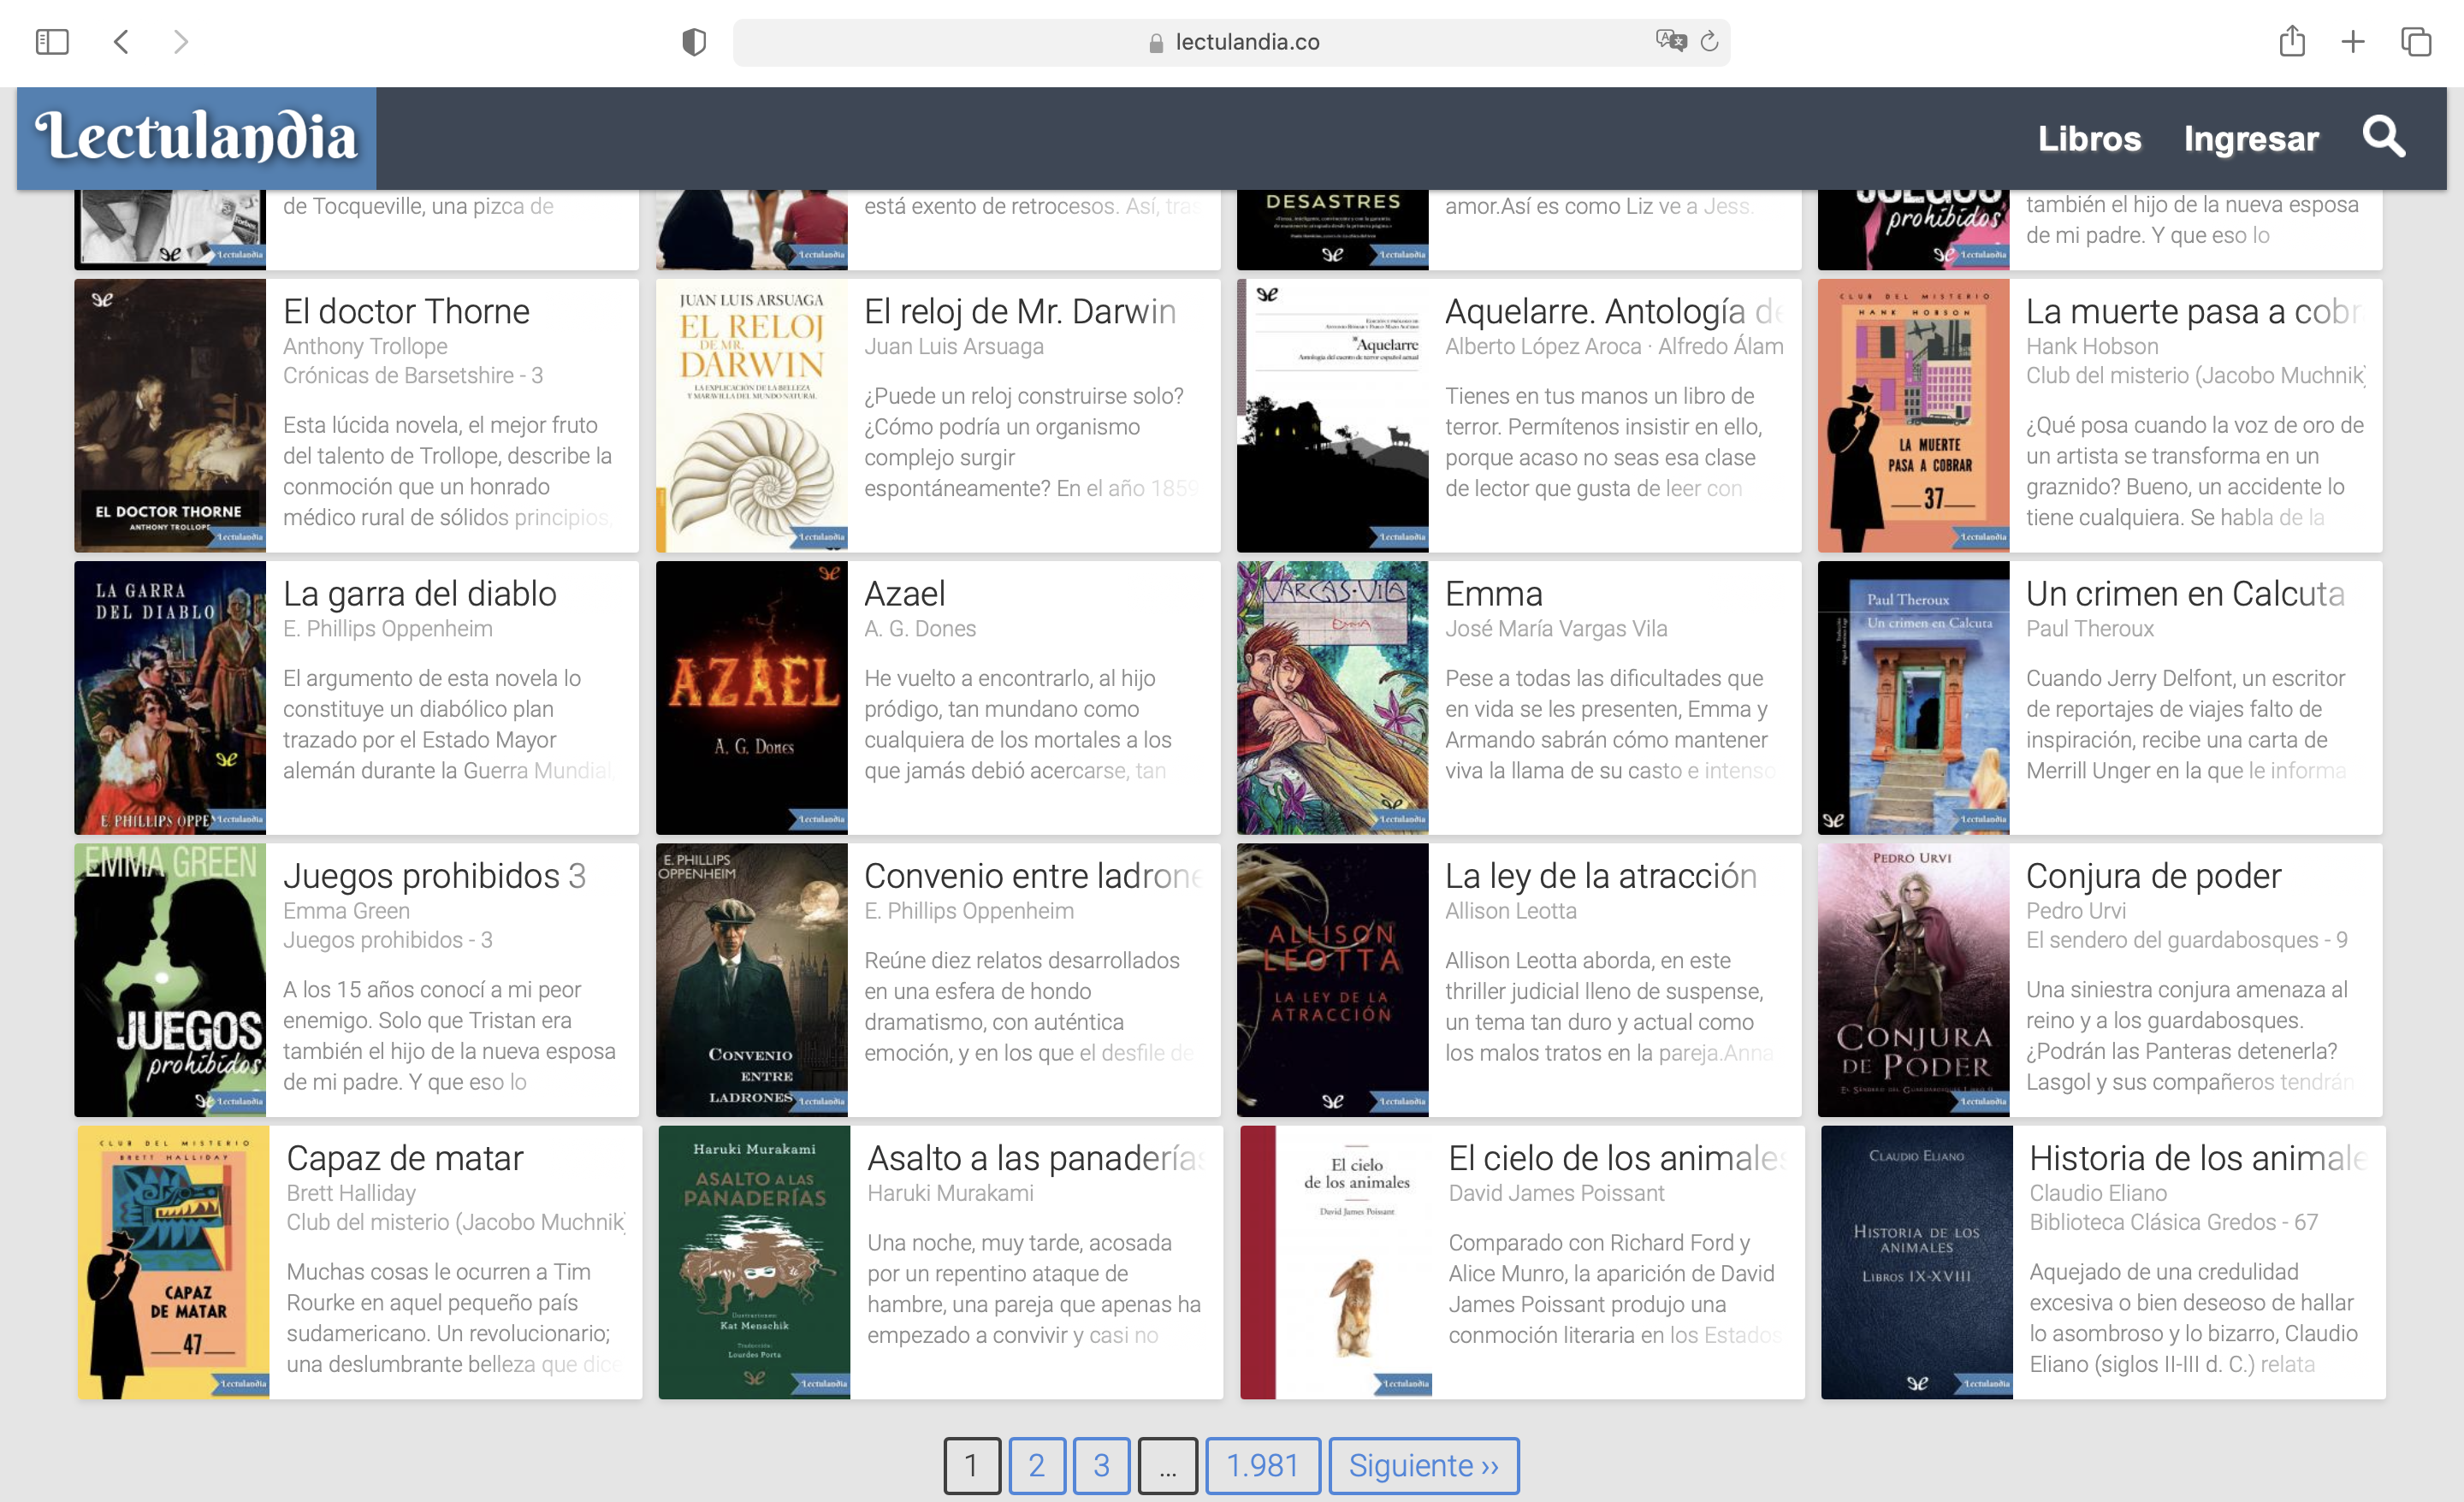

### Review of website with Beautiful Soup:

In [50]:
url = 'https://www.lectulandia.co/book/'
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html')

### Loading created functions for this section:

In [3]:
# Function to extract the list of authors from the website
def get_author(soup_element):    
    _list = []
    
    for line in soup_element.findAll('div', {"class": "subdetail"}): # We loop through every site with book info
        try:
            # if this is an author line we append, it will be -1 if not available
            author_type = line.a.get('href').find('autor')
            if author_type != -1:
                _list.append(line.a.text)
        except Exception: 
            # if the author information hasnt been entered
            # it will display an error, we enter the value as a nan
            # since the information is not available
            _list.append(np.nan)

    return _list

#Function to extract the list of titles and websites to access them
def get_title_and_website(soup_element):
    url = 'https://www.lectulandia.co'
    
    title_list = []
    website_list = []
    
    for line in soup_element.findAll('div')[0].findAll('a', {"class": "title"}):
        
        title_list.append(line.get('title'))
        website_list.append(url + line.get('href'))
    
    return title_list, website_list
    

### Obtaining Data:

We now obtain the scrapped data and add it to the dataframe, we see we have 24 entries, this is the amount of books available per page.

In [4]:
df = pd.DataFrame({'author': get_author(soup), 
                   'title': get_title_and_website(soup)[0],
                  'website': get_title_and_website(soup)[1]})

print('Number of Entries:', df.shape[0])
df.tail()

Number of Entries: 24


author                                    title  \
19            Pedro Urvi                         Conjura de poder   
20        Brett Halliday                           Capaz de matar   
21       Haruki Murakami                  Asalto a las panaderías   
22  David James Poissant                 El cielo de los animales   
23        Claudio Eliano  Historia de los animales Libros IX-XVII   

                                              website  
19  https://www.lectulandia.co/book/conjura-de-poder/  
20    https://www.lectulandia.co/book/capaz-de-matar/  
21  https://www.lectulandia.co/book/asalto-a-las-p...  
22  https://www.lectulandia.co/book/el-cielo-de-lo...  
23  https://www.lectulandia.co/book/historia-de-lo...

## Part 2: Web Scrapping the complete list of books

We will do the same process as before but this time we will loop through every page to obtain the complete list of books.

In [5]:
# We need to know what is the last page to iterate through, since books
# get uploaded all the time this is not static and will change on a daily basis


# The number of the hyperlink to the last page
total_sites = soup.findAll('a', {"class": "page-numbers"})[2] 

# By hav
total_sites = int(total_sites.text.replace(".","")) # We convert this to an int
print('Number of Websites to Scrap:', total_sites)

Number of Websites to Scrap: 1981


In [6]:
for site in range(2, total_sites+1):
    
    # We read each page url and connect with BeautifulSoup
    url = 'https://www.lectulandia.co/book/page/' + str(site) + '/'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html')
    
    # We append the extracted data to our final dataframe
    df_temp = pd.DataFrame({'author': get_author(soup), 
                   'title': get_title_and_website(soup)[0],
                  'website': get_title_and_website(soup)[1]})
    
    df = df.append(df_temp, ignore_index = True)
    
    # print to know progress, this will slow down processing speed
    # but is useful to know where errors might occur
    
    print(str(int(site/total_sites*100))+'%', 'row: ' + str(site) , end = "\r")
    

print('Number of Rows:', df.shape[0])

Number of Rows: 47536


We now have a table with all of the authors, book titles and websites for each book.

In [7]:
df.tail()

author                                    title  \
47531      Gary Jennings                                   Azteca   
47532      J. K. Rowling         Harry Potter y la cámara secreta   
47533      J. K. Rowling  Harry Potter y el prisionero de Azkaban   
47534      J. K. Rowling         Harry Potter y el cáliz de fuego   
47535  Carlos Ruiz Zafón                       El juego del ángel   

                                                 website  
47531            https://www.lectulandia.co/book/azteca/  
47532  https://www.lectulandia.co/book/harry-potter-y...  
47533  https://www.lectulandia.co/book/harry-potter-y...  
47534  https://www.lectulandia.co/book/harry-potter-y...  
47535  https://www.lectulandia.co/book/el-juego-del-a...

## Part 3: Adding information of each book

Each individual page has additional information that we would like to obtain including genre, description, epub download hyperlink and pdf download hyperlink.

### Example of a book website:

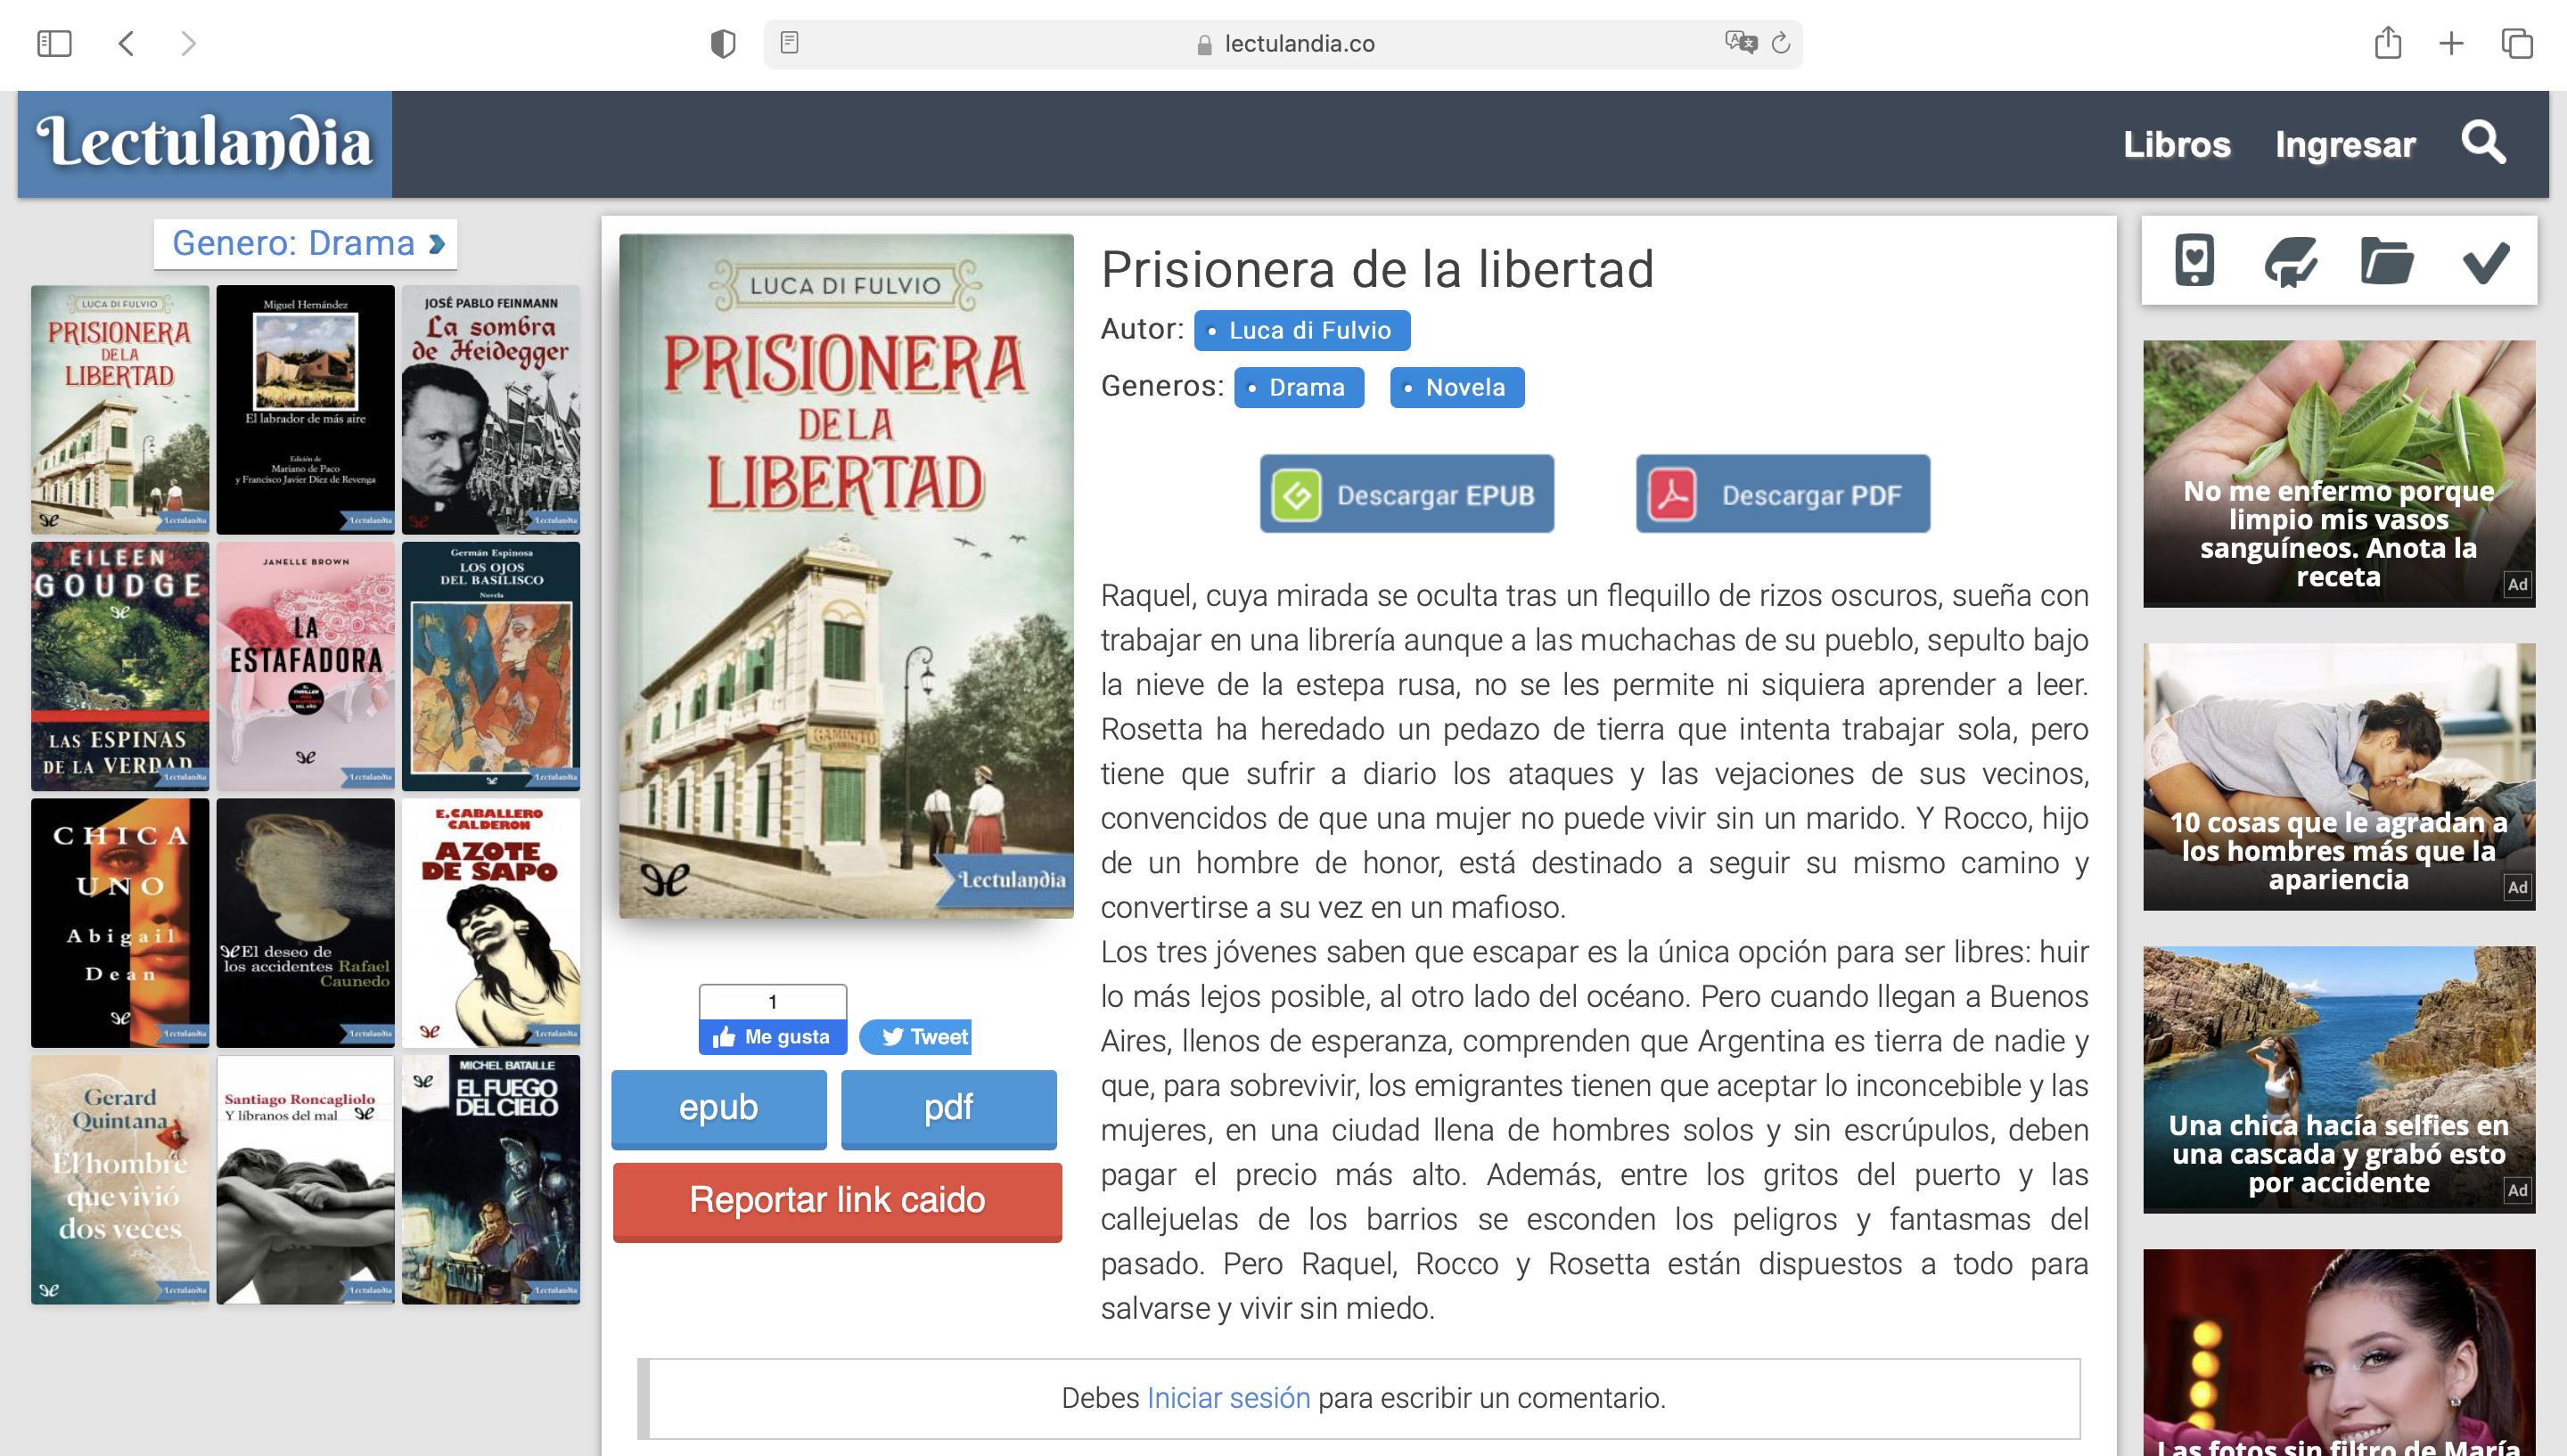

First we load functions created to obtain the information of each column.

In [8]:
# We get the books description:
def get_description(soup_item):

    return soup.find('div', {"class": "realign", "id": "sinopsis"}).text.strip()

# We get the book genre:
def get_genre(soup_item):
    genres = ''
    for line in soup_item.find('div', {"id": "genero"}).findAll('a'):
        genres += line.text + ' / ' # We separate each genre by a '/'
    genres = genres[:-3]
    return genres

def get_website(soup_item):
    base_url = 'https://www.lectulandia.co'
    download = soup_item.find('div', {"id": "downloadContainer"}).findAll('a')
    for dformat in download:
        # we distinguish the hyperlinks by their format and add accordingly
        # to each column
        if not dformat.find('input', {"value": "epub"}) is None:
            download_epub = base_url + dformat.get('href')
        else:
            download_pdf = base_url + dformat.get('href')
    return download_epub, download_pdf

We create the new columns to be filled:

In [9]:
df['genre'] = np.nan
df['description'] = np.nan
df['epub'] = np.nan
df['pdf'] = np.nan
df.head()

author                            title  \
0  Luca di Fulvio        Prisionera de la libertad   
1   Gabi Martínez              Diablo de Timanfaya   
2   Margie Orford            Preciso como un reloj   
3  Silvia Clavell             Una princesa rebelde   
4   Fran Lebowitz  Un día cualquiera en Nueva York   

                                             website  genre  description  \
0  https://www.lectulandia.co/book/prisionera-de-...    NaN          NaN   
1  https://www.lectulandia.co/book/diablo-de-tima...    NaN          NaN   
2  https://www.lectulandia.co/book/preciso-como-u...    NaN          NaN   
3  https://www.lectulandia.co/book/una-princesa-r...    NaN          NaN   
4  https://www.lectulandia.co/book/un-dia-cualqui...    NaN          NaN   

   epub  pdf  
0   NaN  NaN  
1   NaN  NaN  
2   NaN  NaN  
3   NaN  NaN  
4   NaN  NaN

In [10]:
total_sites = df.shape[0]
print('Total Rows to Process:', total_sites)

Total Rows to Process: 47536


Finally we iterate through each books website and obtain more detailed information by book.

In [27]:
for row in range(45693, total_sites):
    # We access each books url
    url = df.loc[row, 'website']
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html')
    
    # We add genre, description and hyperlinks with the created functions
    df.loc[row, 'description'] = get_description(soup)
    df.loc[row,'genre'] = get_genre(soup)
    df.loc[row,'epub'], df.loc[row,'pdf'] = get_website(soup)
    
    # We track progress
    print(str(int(row/total_sites*100))+'%', 'row: ' + str(row) , end = "\r")

df.tail()

author                                    title  \
47531      Gary Jennings                                   Azteca   
47532      J. K. Rowling         Harry Potter y la cámara secreta   
47533      J. K. Rowling  Harry Potter y el prisionero de Azkaban   
47534      J. K. Rowling         Harry Potter y el cáliz de fuego   
47535  Carlos Ruiz Zafón                       El juego del ángel   

                                                 website  \
47531            https://www.lectulandia.co/book/azteca/   
47532  https://www.lectulandia.co/book/harry-potter-y...   
47533  https://www.lectulandia.co/book/harry-potter-y...   
47534  https://www.lectulandia.co/book/harry-potter-y...   
47535  https://www.lectulandia.co/book/el-juego-del-a...   

                                                   genre  \
47531                                        Histórico /   
47532  Aventuras / Fantástico / Infantil y juvenil / ...   
47533  Aventuras / Fantástico / Infantil y juvenil / ...   
47534  Aventuras / Fantástico / Infantil y juvenil / ...   
47535                                          Intriga /   

                                             description  \
47531  Año: 1980\nSinopsis: 'Azteca' está escrita com...   
47532  Tras derrotar una vez más a lord Voldemort, su...   
47533  Por la cicatriz que lleva en la frente, sabemo...   
47534  Tras otro abominable verano con los Dursley, H...   
47535  Año: 2008 Sinopsis:El Juego del Ángel es una g...   

                                                    epub  \
47531  https://www.lectulandia.co/download.php?t=1&d=...   
47532  https://www.lectulandia.co/download.php?t=1&d=...   
47533  https://www.lectulandia.co/download.php?t=1&d=...   
47534  https://www.lectulandia.co/download.php?t=1&d=...   
47535  https://www.lectulandia.co/download.php?t=1&d=...   

                                                     pdf  
47531  https://www.lectulandia.co/download.php?t=2&d=...  
47532  https://www.lectulandia.co/download.php?t=2&d=...  
47533  https://www.lectulandia.co/download.php?t=2&d=...  
47534  https://www.lectulandia.co/download.php?t=2&d=...  
47535  https://www.lectulandia.co/download.php?t=2&d=...

## Part 4: Saving Dataframe to a CSV file

As backup we save the file to a csv, this file has utf-8-sig encoding to maintain the spanish characters on the csv file.

In [28]:
df.to_csv("book_df.csv", encoding="utf-8-sig", index="False")